# **Compressing Data via Dimensionality Reduction**


### Overview

- Unsupervised dimensionality reduction via principal component analysis
    - The main steps behind principal component analysis
    - Extracting the principal components step-by-step
    - Total and explained variance
    - Feature transformation
    - Principal component analysis in scikit-learn
    - Assessing feature contributions

- Supervised data compression via linear discriminant analysis
    - Principal component analysis versus linear discriminant analysis
    - The inner workings of linear discriminant analysis
    - Computing the scatter matrices
    - Selecting linear discriminants for the new feature subspace
    - Projecting examples onto the new feature space
    - LDA via scikit-learn

- Nonlinear dimensionality reduction techniques
    - Visualizing data via t-distributed stochastic neighbor embedding

- Summary

## Unsupervised dimensionality reduction via principal component analysis

Similar to feature selection, we can use different feature extraction technique to reduce the number of features in a dataset. The difference between feature selection and feature extraction is that while we maintain the original features when we use feature selection algorithms, such as `sequential backward selection`, we use feature extraction to transform or project the data onto a new feature space.

In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm but can also improve the predictive performance by reducing the `curse of dimensionality`, especially if we are working with non-regularized models.

### The main steps behind principal component analysis

`Principal Component Analysis (PCA)` is a `linear transformation` technique used in statistics and machine learning for:

- Data visualization
- Dimensionality reduction
- Pattern recognition
- Feature extraction before modeling
- Noise elimination / filtering
- Preprocessing for clustering or regression

It re-expresses the data in terms of `principal components` — new variables formed as `orthogonal linear combinations` of the original features that capture maximum variance.


PCA helps to identify patterns in data based on the correlation between features. PCA aims to find the directions of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum vairance given the constraint that the new feature axes are orthogonal to each other.


![Principal Component Analysis](./figures/pca.png)



- Refer to [Principal Component Analysis](https://github.com/Sillians/mathematics_for_ml/tree/main/Applications_Linear_Algebra/Principal_component_analysis), for more information about the mathematical intuition behind PCA.

As a result of transforming the original `d-dimensional` data onto this new `k-dimensional` subspace (typically `k << d`), the first principal component will have the largest possible variance. All consequent principal components will have the largest variance given the constraint that these components are
uncorrelated (orthogonal) to the other principal components—even if the input features are correlated, the resulting principal components will be mutually orthogonal (uncorrelated). Note that the PCA directions are highly sensitive to data scaling, and we need to standardize the features prior to PCA if
the features were measured on different scales and we want to assign equal importance to all features.


Before looking at the PCA algorithm for dimensionality reduction in more detail, let’s summarize the approach in a few simple steps:

- Standardize the `d-dimensional` dataset.
- Construct the covariance matrix.
- Decompose the covariance matrix into its eigenvectors and eigenvalues.
- Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
- Select `k` eigenvectors, which correspond to the `k` largest eigenvalues, where `k` is the dimensionality of the new feature subspace `(k <= d)`.
- Construct a projection matrix, `W`, from the `“top”` k eigenvectors.
- Transform the `d-dimensional` input dataset, `X`, using the projection matrix, `W`, to obtain the new `k-dimensional` feature subspace.

**Eigendecomposition: Decomposing a Matrix into Eigenvectors and Eigenvalues**

`Eigendecomposition`, the factorization of a square matrix into so-called `eigenvalues` and `eigenvectors`, is at the core of the PCA procedure described in this section. The covariance matrix is a special case of a square matrix: it’s a symmetric matrix, which means that the matrix is equal to its transpose, 

$`A = A^{T}`$.

When we decompose such a symmetric matrix, the eigenvalues are real (rather than complex) numbers, and the eigenvectors are orthogonal (perpendicular) to each other. Furthermore, eigenvalues and eigenvectors come in pairs. If we decompose a covariance matrix into its eigenvectors and eigenvalues, the eigenvectors associated with the highest eigenvalue corresponds to the direction of maximum variance in the dataset. Here, this “direction” is a linear transformation of the dataset’s feature columns.

### Extracting the principal components step by step

In this subsection, we will tackle the first four steps of a PCA:

1. Standardizing the data
2. Constructing the covariance matrix
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors

In [5]:
import pandas as pd
wine_data_path = "../data/wine/wine.data"

df_wine = pd.read_csv(wine_data_path, header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- Splitting the data into `70%` training and `30%` test subsets.

In [6]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

- standardizing the data

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
X_train_std.mean(), X_train_std.std()

(np.float64(9.124215031162576e-16), np.float64(1.0))

**Eigendecomposition of the covariance matrix.**

In [10]:
# function from NumPy to obtain the eigenpairs of the Wine covariance matrix:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [12]:
cov_mat.shape

(13, 13)

- Using the `numpy.cov` function, we computed the covariance matrix of the standardized training dataset. Using the `linalg.eig` function, we performed the `eigendecomposition`, which yielded a vector (eigen_vals) consisting of `13 eigenvalues` and the corresponding `eigenvectors` stored as columns in
a 13×13-dimensional matrix (eigen_vecs).

In [16]:
eign_val = np.linalg.eigvals(cov_mat)
eign_val

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

### **Total and explained variance**

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the `eigenvectors (principal components)` that contains most of the information (variance). The `eigenvalues` define the magnitude of the `eigenvectors`, so we have to sort the
`eigenvalues` by decreasing magnitude; we are interested in the top `k eigenvectors` based on the values of their corresponding eigenvalues. 

- Using the NumPy `cumsum` function, we can then calculate the cumulative sum of explained variances, which we will then plot via Matplotlib’s step function:

In [23]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.36951469, 0.55386396, 0.67201555, 0.74535807, 0.80957914,
       0.86009639, 0.89964293, 0.92608211, 0.9499753 , 0.96627144,
       0.98007165, 0.99179391, 1.        ])

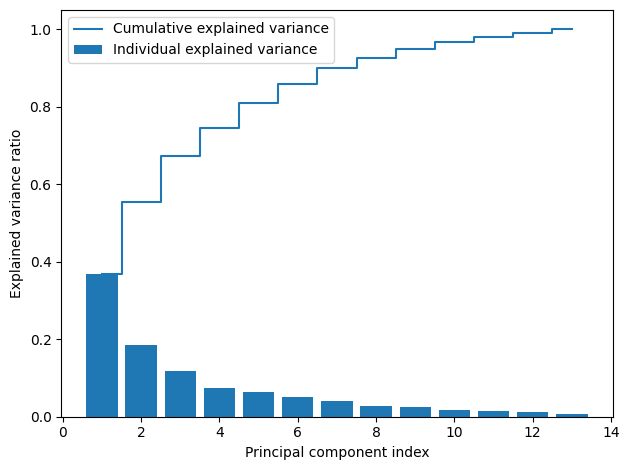

In [27]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), 
        var_exp, 
        align='center',
        label='Individual explained variance')

plt.step(range(1, 14), 
         cum_var_exp, 
         where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/05_02.png', dpi=300)
plt.show()

- The resulting plot indicates that the first principal component alone accounts for approximately `40 percent` of the variance. Also, we can see that the first two principal components combined explain almost `60 percent` of the variance in the dataset.

- Although the explained variance plot reminds us of the feature importance values that we computed via `random forests`, we should remind ourselves that PCA is an unsupervised method, which means that information about the class labels is ignored. Whereas a `random forest` uses the class membership information to compute the node `impurities`, `variance` measures the spread of values along a feature axis.

### **Feature transformation**

Now that we have successfully decomposed the covariance matrix into eigenpairs, let’s proceed with the last three steps to transform the Wine dataset onto the new principal component axes. The remaining steps we are going to tackle in this section are the following:

- Select `k` eigenvectors, which correspond to the `k` largest eigenvalues, where `k` is the dimensionality of the new feature subspace `(k <= d)`.

- Construct a projection matrix, `W`, from the `“top”` k eigenvectors.

- Transform the `d-dimensional` input dataset, `X`, using the projection matrix, `W`, to obtain the new `k-dimensional` feature subspace.


Or, in less technical terms, we will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the `lower-dimensional subspace`.

- We start by sorting the eigenpairs by decreasing order of the eigenvalues

In [28]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [29]:
eigen_pairs

[(np.float64(4.842745315655894),
  array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
         -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
         -0.32613263, -0.36861022, -0.29669651])),
 (np.float64(2.416024587035225),
  array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
          0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
         -0.20716433, -0.24902536,  0.38022942])),
 (np.float64(1.54845824882035),
  array([-0.13774873,  0.09615039,  0.67777567,  0.62504055,  0.19613548,
          0.14031057,  0.11705386,  0.13121778,  0.0304309 , -0.07992997,
          0.05305915,  0.13239103, -0.07065022])),
 (np.float64(0.9612043774977371),
  array([-0.0032961 ,  0.56264669, -0.10897711,  0.0338187 , -0.36751107,
          0.24024513,  0.1870533 , -0.02292622,  0.49626233,  0.10648294,
         -0.36905375,  0.14201609, -0.16768217])),
 (np.float64(0.8416616104578407),
  array([-0.29062523,  0.08953787, -0.

Next, we collect the two `eigenvectors` that correspond to the two largest `eigenvalues`, to capture about `60 percent` of the variance in this dataset. Note that two eigenvectors have been chosen for the purpose of illustration, since we are going to plot the data via a `two-dimensional` scatterplot later in this subsection. In practice, the number of principal components has to be determined by a tradeoff between `computational efficiency` and the performance of the classifier:

In [30]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [35]:
w.shape

(13, 2)

- By executing the preceding code, we have created a `13×2-dimensional` projection matrix, `W`, from the top two eigenvectors.

- Using the projection matrix, we can now transform an example, $x$ (represented as a 13-dimensional row vector), onto the PCA subspace (the principal components one and two) obtaining $x^{'}$, now a `two-dimensional` example vector consisting of two new features:

$$x^{'} = xW$$

In [41]:
X_train_std[0].shape, w.shape

((13,), (13, 2))

In [43]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

- Similarly, we can transform the entire  `124×13-dimensional` training dataset onto the two principal components by calculating the matrix dot product:

In [45]:
X_train_pca = X_train_std.dot(w)
X_train_pca.shape

(124, 2)

- Lastly, let’s visualize the transformed Wine training dataset, now stored as an `124×2-dimensional` matrix, in a two-dimensional scatterplot:

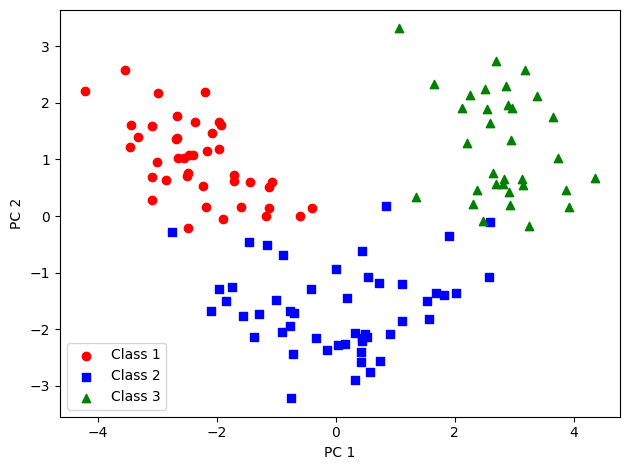

In [46]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_03.png', dpi=300)
plt.show()

- As we can see in the plot above, the data is more spread along the first principal component `(x axis)` than the second principal component `(y axis)`, which is consistent with the explained variance ratio plot that we created in the previous subsection. However, we can tell that a linear classifier will likely be
able to separate the classes well.


- Although we encoded the class label information for the purpose of illustration in the preceding scatterplot, we have to keep in mind that `PCA` is an unsupervised technique that doesn’t use any class label information.

## **Principal component analysis in scikit-learn**

In [47]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

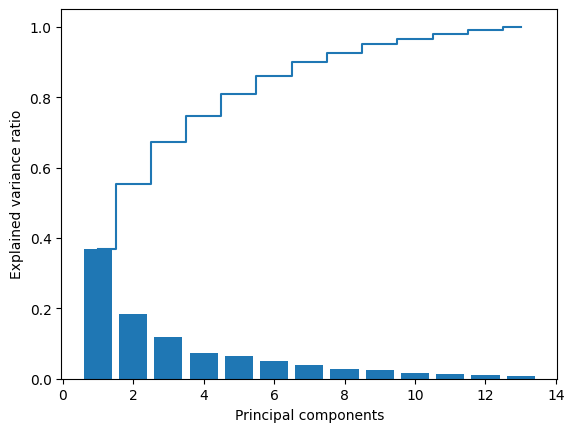

In [48]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [49]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

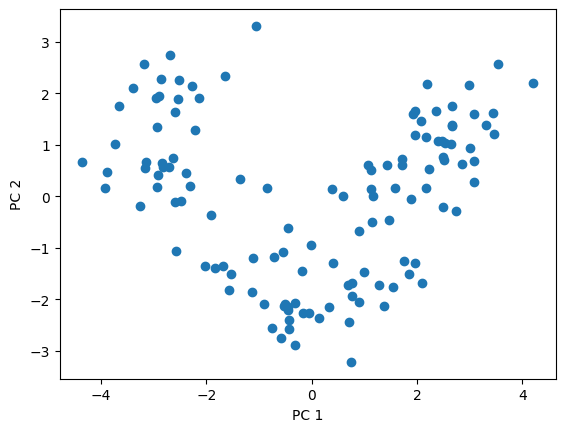

In [50]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

- The `PCA` class is another one of scikit-learn’s transformer classes, with which we first fit the model using the training data before we transform both the training data and the test dataset using the same model parameters

- Now, let’s use the `PCA` class from scikit-learn on the Wine training dataset, classify the transformed examples via logistic regression, and visualize the decision regions via the `plot_decision_regions` function.

- Training `logistic regression` classifier using the first `2 principal components`.

In [71]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

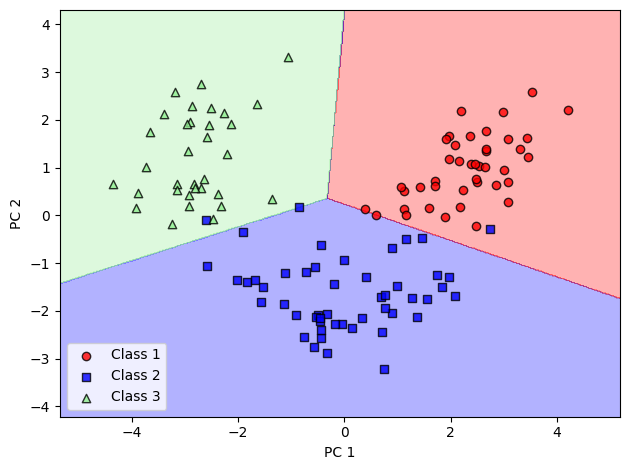

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


# initializing the PCA transformer and logistic regression estimator.
pca = PCA(n_components=2)
lr = OneVsRestClassifier(LogisticRegression(random_state=1,
                                            solver='lbfgs'))

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# fitting the logistic regression model on the reduced dataset:
lr = lr.fit(X_train_pca, y_train)

# plotting
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_04.png', dpi=300)
plt.show()

- When we compare the `PCA` projections via scikit-learn with our own `PCA` implementation, we might see that the resulting plots are mirror images of each other. Note that this is not due to an error in either of those two implementations; the reason for this difference is that, depending on the eigensolver, eigenvectors can have either negative or positive signs.

- Not that it matters, but we could simply revert the mirror image by multiplying the data by `–1` if we wanted to; note that eigenvectors are typically scaled to unit length `1`. For the sake of completeness, let’s plot the decision regions of the logistic regression on the transformed test dataset to see if it can separate the classes well:

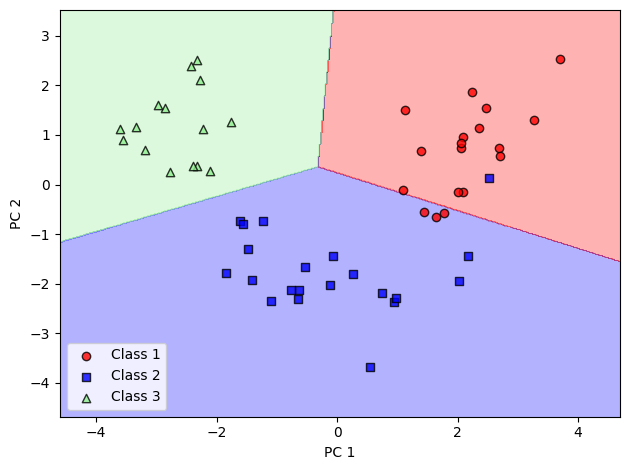

In [74]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [77]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
vrr = pca.explained_variance_ratio_
vrr

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [78]:
vrr.sum()

np.float64(1.0000000000000002)

### **Assessing feature contributions**

- In this section, we will take a brief look at how we can assess the contributions of the original features to the principal components. As we learned, via `PCA`, we create principal components that represent linear combinations of the features. Sometimes, we are interested to know about how much each original feature contributes to a given principal component. These contributions are often called loadings.

- The factor loadings can be computed by scaling the `eigenvectors` by the square root of the `eigenvalues`. The resulting values can then be interpreted as the correlation between the original features and the principal component.

- First, we compute the `13×13-dimensional` loadings matrix by multiplying the eigenvectors by the square root of the eigenvalues:

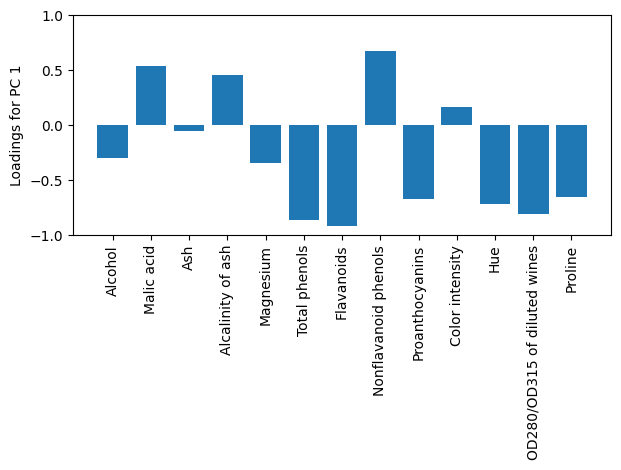

In [ ]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
#plt.savefig('figures/05_05_02.png', dpi=300)
plt.show()

In [80]:
loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

- In the preceding code example, we compute the factor loadings for our own `PCA` implementation. We can obtain the loadings from a fitted scikit-learn `PCA` object in a similar manner, where `pca.components_` represents the eigenvectors and `pca.explained_variance_` represents the eigenvalues:

- To compare the scikit-learn PCA loadings with those we created previously, let us create a similar bar plot

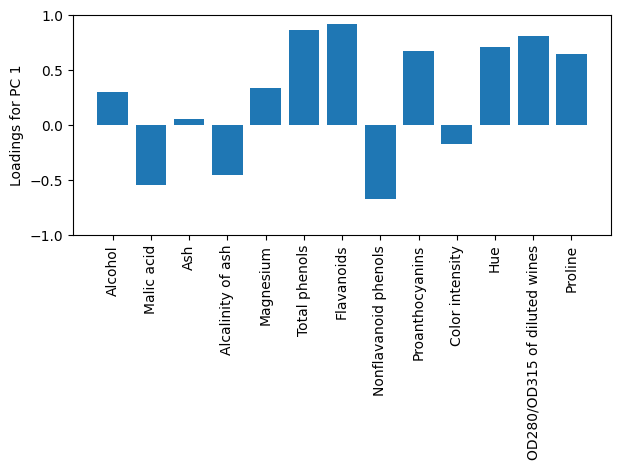

In [ ]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
#plt.savefig('figures/05_05_03.png', dpi=300)
plt.show()

## **Supervised data compression via linear discriminant analysis**

`LDA` can be used as a technique for feature extraction to increase computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models. The general concept behind `LDA` is very similar to PCA, but whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in `LDA` is to find the feature subspace that optimizes class separability. 


`Linear Discriminant Analysis (LDA)` is a supervised classification and dimensionality reduction technique that maximizes class separation by finding a linear combination of features to project high-dimensional data into a lower-dimensional space. It accomplishes this by creating new axes that simultaneously maximize the distance between the means of different classes and minimize the scatter (variation) within each class. LDA is particularly useful for tasks like 

- face recognition, 
- medical diagnosis, and 
- customer segmentation where distinguishing between known categories is key.


### Principal component analysis versus linear discriminant analysis

Both PCA and LDA are `linear transformation techniques` that can be used to reduce the number of dimensions in a dataset; the former is an unsupervised algorithm, whereas the latter is supervised. Thus, we might think that LDA is a superior feature extraction technique for classification tasks compared to PCA.


![LDA](./figures/LDA.png)


One assumption in `LDA` is that the data is normally distributed. Also, we assume that the classes have identical covariance matrices and that the training examples are statistically independent of each other. However, even if one, or more, of those assumptions is (slightly) violated, `LDA` for dimensionality reduction can still work reasonably well.

### The inner workings of linear discriminant analysis

The main steps that are required to perform LDA:

- Standardize the `d-dimensional` dataset (`d` is the number of features).
- For each class, compute the `d-dimensional` mean vector.
- Construct the between-class scatter matrix, $S_{B}$, and the within-class scatter matrix, $S_{W}$.
- Compute the eigenvectors and corresponding eigenvalues of the matrix, $S^{-1}_{W}$ $S_{B}$.
- Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
- Choose the `k` eigenvectors that correspond to the `k` largest eigenvalues to construct a `dxk-dimensional` transformation matrix, $W$; the eigenvectors are the columns of this matrix.
- Project the examples onto the new feature subsapce using the transformation matrix, $W$.


As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues and eigenvectors, which will form the new `lower-dimensional` feature space. However, as mentioned before, LDA takes `class label` information into account, which is represented in the form of the `mean vectors` computed in step 2. 

#### Computing the scatter matrices

Since we already standardized the features of the Wine dataset in the PCA section, we can skip the first step and proceed with the calculation of the mean vectors, which we will use to construct the `within-class` scatter matrix and `between-class` scatter matrix, respectively. Each mean vector, $m_{i}$, stores the mean feature value, $\mu_{m}$, with respect to the examples of class $i$

- Calculate the mean vectors for each class:

In [82]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



- Compute the within-class scatter matrix:

In [90]:
d = 13 # number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


- The assumption that we are making when we are computing the scatter matrices is that the class labels in the training dataset are uniformly distributed. However, if we print the number of class labels, we see that this assumption is violated:

In [91]:
print('Class label distribution:',  
      np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


- Compute the scaled within-class scatter matrix as follows:

In [101]:
d = 13  # number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


- Compute the between-class scatter matrix

In [102]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: '
      f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


### **Selecting linear discriminants for the new feature subspace**

The remaining steps of the `LDA` are similar to the steps of the `PCA`. However, instead of performing the eigendecomposition on the covariance matrix, we solve the generalized eigenvalue problem of the matrix, $S_{W}^{-1} S_{B}$:

In [103]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

- Sort eigenvectors in descending order of the eigenvalues:

In [104]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979382
2.7905434564890647e-14
2.736061413582339e-14
2.736061413582339e-14
2.1843470083407988e-14
1.8136771261205975e-14
1.8136771261205975e-14
1.435931167587541e-14
1.435931167587541e-14
5.023701006635386e-15
2.335354240931274e-15
0.0


- To measure how much of the `class-discriminatory` information is captured by the linear discriminants (eigenvectors), let’s plot the `linear discriminants` by decreasing eigenvalues, similar to the explained variance plot that we created in the PCA section. For simplicity, we will call the content of class-discriminatory information `discriminability`:

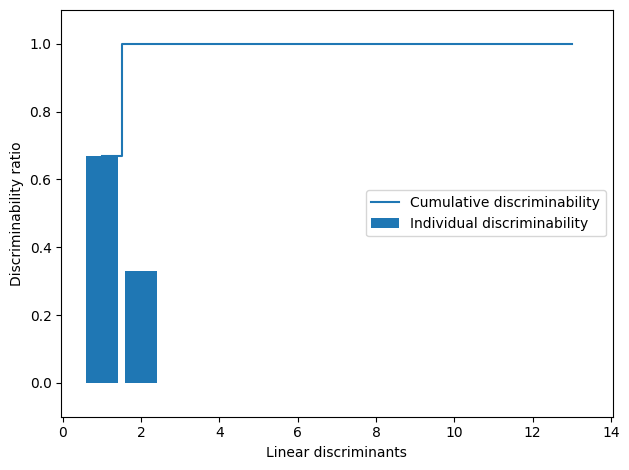

In [142]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/05_07.png', dpi=300)
plt.show()

- Let’s now stack the two most discriminative eigenvector columns to create the transformation matrix, `W`:

In [ ]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### **Projecting examples onto the new feature space**

Using the transformation matrix `W` that we created in the previous subsection, we can now transform the training dataset by multiplying the matrices:

$$X^{'} = XW$$

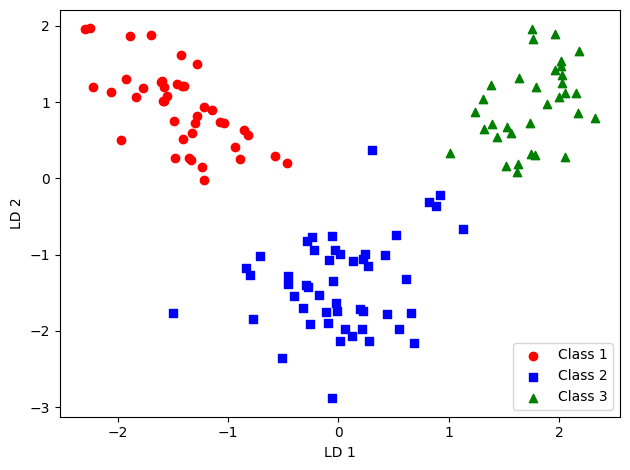

In [144]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/05_08.png', dpi=300)
plt.show()

## **LDA via scikit-learn**

The step-by-step implementation was a good exercise to understand the inner workings of `LDA` and understand the differences between `LDA` and `PCA`. Now, let's look at the `LDA` class implemented in scikit-learn:

In [145]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

- Next, let’s see how the logistic regression classifier handles the lower-dimensional training dataset
after the LDA transformation:

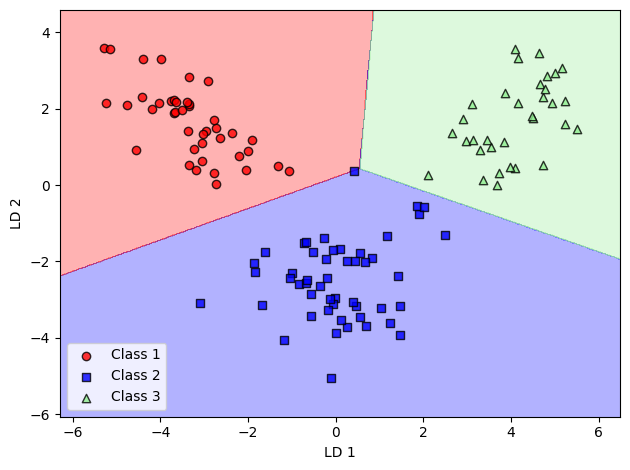

In [146]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

lr = OneVsRestClassifier(LogisticRegression(
    random_state=1,
    solver='lbfgs'
))
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_09.png', dpi=300)
plt.show()

- By lowering the regularization strength, we could probably shift the decision boundaries so that the
logistic regression model classifies all examples in the training dataset correctly. However, and more
importantly, let’s take a look at the results on the test dataset:

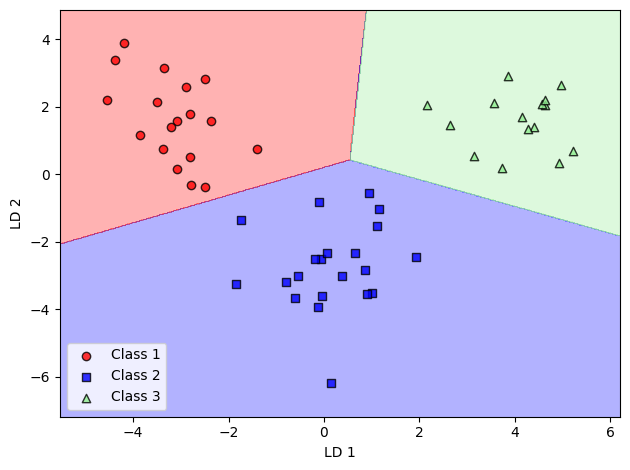

In [147]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_10.png', dpi=300)
plt.show()

## **Nonlinear dimensionality reduction techniques**

In this section, we will discuss why considering nonlinear dimensionality reduction techniques might be worthwhile.

One `nonlinear dimensionality` reduction technique that is particularly worth highlighting is `t-distributed stochastic neighbor embedding (t-SNE)` since it is frequently used in literature to visualize high-dimensional datasets in two or three dimensions. We will see how we can apply t-SNE to plot images of handwritten images in a 2-dimensional feature space.

### **Why consider nonlinear dimensionality reduction?**

Many machine learning algorithms make assumptions about the linear separability of the input data. You have learned that the perceptron even requires perfectly linearly separable training data to converge. Other algorithms that we have covered so far assume that the lack of perfect linear separability is due to noise: Adaline, logistic regression, and the (standard) SVM to just name a few.

However, if we are dealing with nonlinear problems, which we may encounter rather frequently in real-world applications, linear transformation techniques for dimensionality reduction, such as `PCA` and `LDA`, may not be the best choice:


![Linear and Non Linear Problems](./figures/linear-non-linear.png)


The development and application of nonlinear dimensionality reduction techniques is also often referred to as manifold learning, where a manifold refers to a lower dimensional topological space embedded in a high-dimensional space. Algorithms for manifold learning have to capture the complicated structure of the data in order to project it onto a lower-dimensional space where the relationship between data points is preserved.

![3D Swiss Roll Projected into a lower, 2D space](./figures/swiss-roll.png)



While nonlinear dimensionality reduction and manifold learning algorithms are very powerful, we should note that these techniques are notoriously hard to use, and with non-ideal hyperparameter choices, they may cause more harm than good. The reason behind this difficulty is that we are often working with high-dimensional datasets that we cannot readily visualize and where the structure is not obvious. Moreover, unless we project the dataset into two or three dimensions (which is often not sufficient for capturing more complicated relationships), it is hard or even impossible to assess the quality of the results. Hence, many people still rely on simpler techniques such as `PCA` and `LDA` for dimensionality reduction.

### **Visualizing data via t-distributed stochastic neighbor embedding**

`t-SNE (t-Distributed Stochastic Neighbor Embedding)` is a dimensionality reduction algorithm, primarily used for visualizing high-dimensional data by embedding it into a low-dimensional space (typically 2D or 3D). It works by converting similarities between data points in the high-dimensional space into joint probabilities, aiming to preserve the local structure and reveal clusters by ensuring that points close in the original data remain close in the low-dimensional embedding.



**How t-SNE Works**

- `Similarity Calculation:` t-SNE first calculates the similarity between every pair of data points in the high-dimensional space, turning these similarities into probabilities. 

- `Probability Conversion:` These probabilities are converted into conditional probabilities, which represent the likelihood of one point picking another as a neighbor. 

- `Low-Dimensional Embedding:` It then creates a similar probability distribution in the lower-dimensional space. 

- `Minimizing Divergence:` The algorithm iteratively moves points in the low-dimensional space to minimize the divergence between the high-dimensional and low-dimensional probability distributions, striving to make points that were similar in the original space remain close together. 




**Key Features and Uses**

- `Visualizing Clusters:` Its primary use is to visualize complex datasets, revealing natural clusters and patterns that would otherwise be hidden. 

- `Preserving Local Structure:` t-SNE excels at capturing the local relationships between data points. 

- `Unsupervised Learning:` It is an unsupervised algorithm, meaning it doesn't require labeled data to perform its task. 

- `Versatile Applications:` t-SNE is widely used in various fields, including bioinformatics (e.g., single-cell RNA sequencing), to visualize gene expression data, and to understand large datasets from fields like mass cytometry. 




**Important Considerations**

- `Non-Convex Cost Function:` The algorithm's cost function is not convex, meaning different initializations can lead to different results, according to Scikit-learn. 

- `Computational Cost:` For very high-dimensional datasets, it's often recommended to use another method, like `PCA`, to reduce the number of dimensions before applying `t-SNE` to speed up computations. 

- `Iterative Process:` Unlike `PCA`, `t-SNE` is an iterative process and not suitable for directly transforming new data using a pre-computed transformation matrix


- The followig code shows a quick demonstration of how `t-SNE` can be applied to a 64-dimensional dataset. First, we load the Digits dataset from scikit-learn, which consists of low-resolution handwritten ten digits (the numbers 0-9):

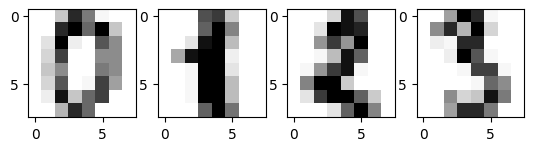

In [148]:
from sklearn.datasets import load_digits

digits = load_digits()
fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
    
# plt.savefig('figures/05_12.png', dpi=300)
plt.show() 

In [150]:
digits.data.shape

(1797, 64)

- Now, let us assign the features (pixels) to a new variable `X_digits` and the labels to another new variable `y_digits`:

In [151]:
y_digits = digits.target
X_digits = digits.data

- Then, we import the `t-SNE` class from scikit-learn and fit a new tsne object. Using `fit_transform`, we perform the `t-SNE` fitting and data transformation in one step:

In [152]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

- Using this code, we projected the `64-dimensional` dataset onto a `2-dimensional` space. We specified `init = pca`, which initializes the `t-SNE` embedding using `PCA`. 


- Note that t-SNE includes additional hyperparameters such as the perplexity and learning rate (often called epsilon), which we omitted in the example (we used the scikit-learn default values). In practice, we recommend you explore these parameters as well. 

- Finally, let us visualize the `2D t-SNE` embeddings using the following code:

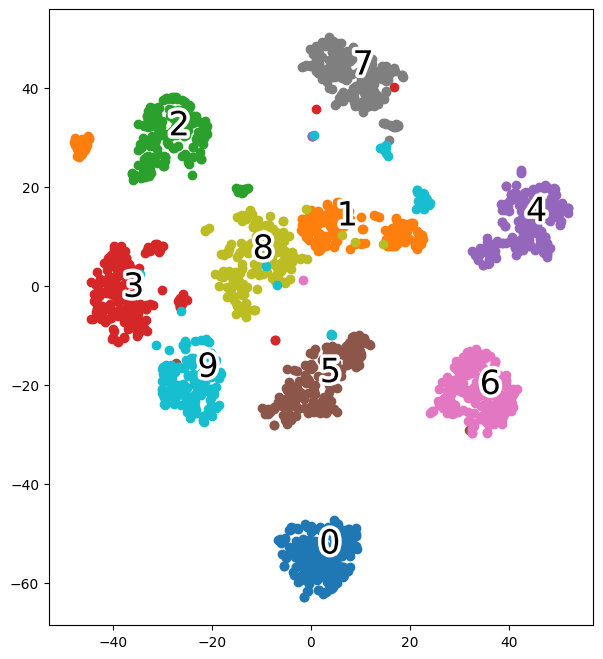

In [153]:
import matplotlib.patheffects as PathEffects

def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
# plt.savefig('figures/05_13.png', dpi=300)
plt.show()

- Like `PCA`, `t-SNE` is an unsupervised method, and in the preceding code, we use the class labels `y_digits (0-9)` only for visualization purposes via the functions color argument.

- Matplotlib’s PathEffects are used for visual purposes, such that the class label is displayed in the center (via np.median) of data points belonging to each respective digit.

- As we can see, `t-SNE` is able to separate the different digits (classes) nicely, although not perfectly. It might be possible to achieve better separation by tuning the hyperparameters. However, a certain degree of class mixing might be unavoidable due to illegible handwriting.